Removing non-numeric columns: ['File', 'Interval']

Sample-Level Metrics:
Accuracy: 0.6489
Precision: 0.4842
Recall (Sensitivity): 0.2738
Specificity: 0.8464
F1 Score: 0.3498
Loss: 0.3511

Patient-Level Metrics:
Accuracy: 0.8400
Precision: 1.0000
Recall (Sensitivity): 0.3333
Specificity: 1.0000
F1 Score: 0.5000
Loss: 0.1600


E:\karthick\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\karthick\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\karth\AppData\Local\Temp\ipykernel_17104\1589382943.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby t

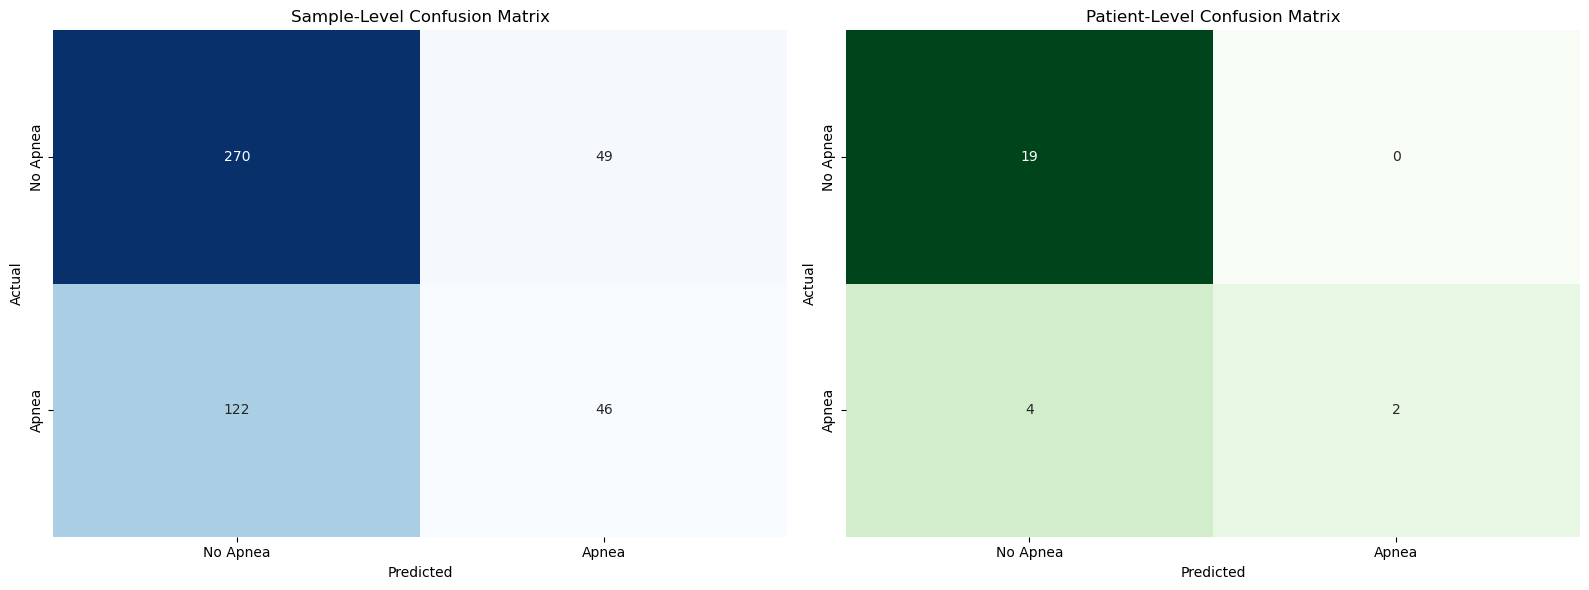

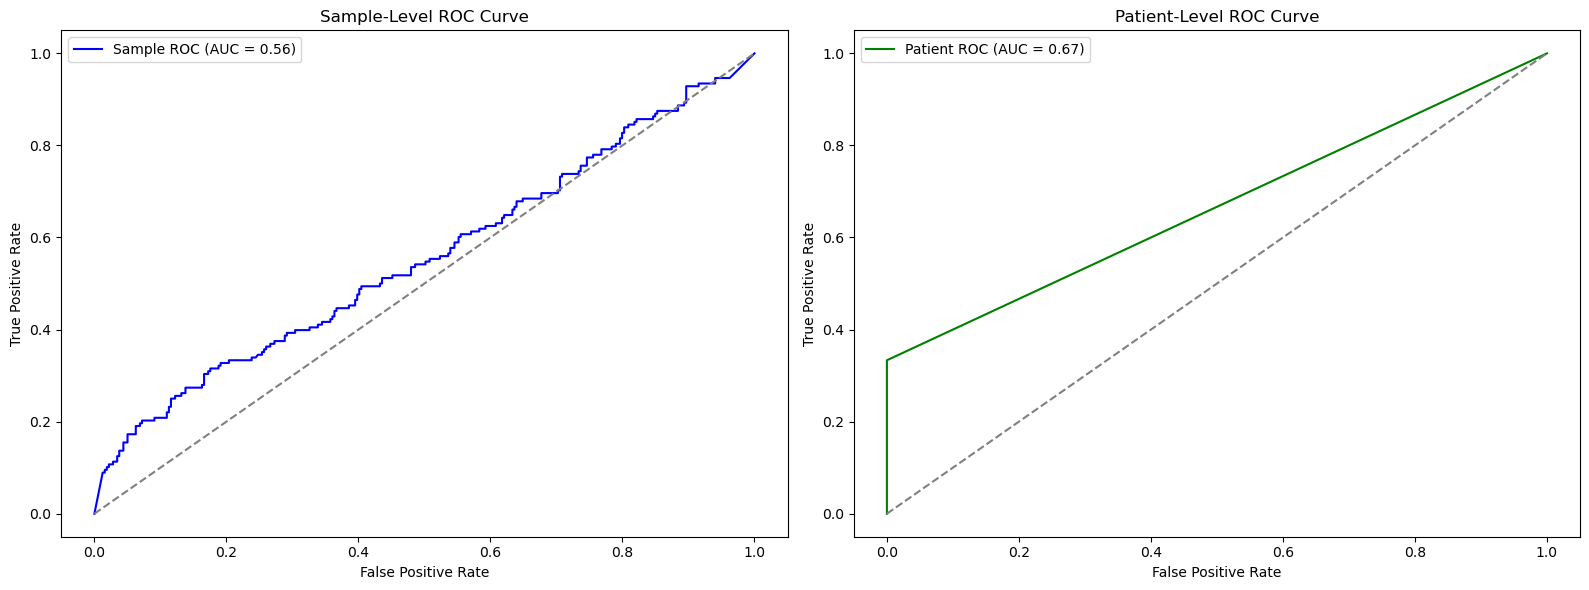

C:\Users\karth\AppData\Local\Temp\ipykernel_17104\1589382943.py:221: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_patient_results = train_df.groupby('patient_id').apply(lambda x: pd.Series({
C:\Users\karth\AppData\Local\Temp\ipykernel_17104\1589382943.py:228: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_patient_results = test_df.groupby('patient_id').apply(lambda x: pd.Series({
C:\Users\karth\A

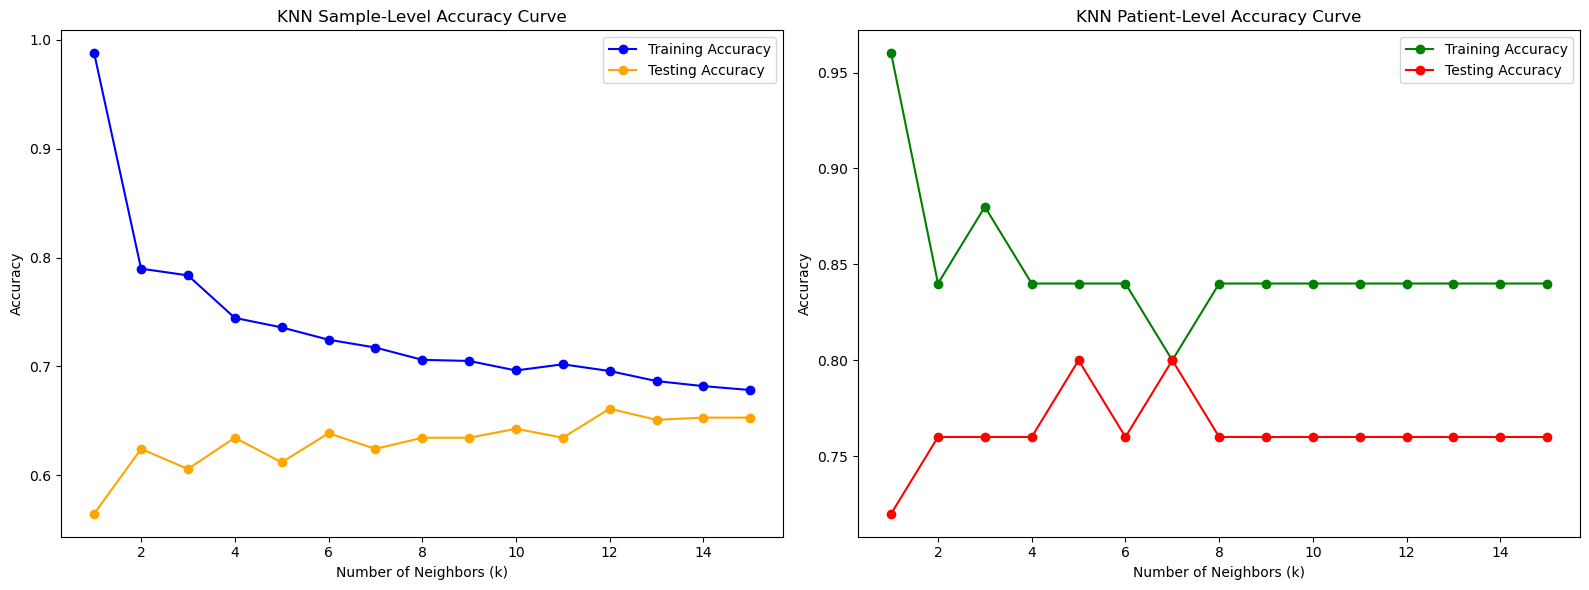

In [65]:
# ==========================================
# Step 1: Import Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, log_loss
)

# ==========================================
# Step 2: Load and Preprocess Data
# ==========================================
# Load your data
data = pd.read_csv('labelled_ecg_features.csv')

# Drop missing values
data = data.dropna()

# Extract patient IDs
if 'patient_id' in data.columns:
    patient_ids = data['patient_id']
    data = data.drop('patient_id', axis=1)
else:
    patient_ids = pd.Series(np.random.randint(1, 26, len(data)))

# Extract features and labels
X = data.drop('Apnea_Label', axis=1)
y = data['Apnea_Label']

# Remove non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'string']).columns
if len(non_numeric_cols) > 0:
    print(f"Removing non-numeric columns: {list(non_numeric_cols)}")
    X = X.drop(non_numeric_cols, axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets with patient IDs
X_train, X_test, y_train, y_test, train_pids, test_pids = train_test_split(
    X_scaled, y, patient_ids, test_size=0.2, stratify=patient_ids, random_state=42
)

# ==========================================
# Step 3: KNN Model with Hyperparameter Tuning
# ==========================================
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_

# Predictions
y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:, 1]

# ==========================================
# Step 4: Sample-Level Evaluation
# ==========================================
# Sample-level confusion matrix
sample_conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = sample_conf_matrix.ravel()

# Sample-level metrics
sample_accuracy = accuracy_score(y_test, y_pred)
sample_precision = precision_score(y_test, y_pred)
sample_recall = recall_score(y_test, y_pred)  # Sensitivity
sample_f1 = f1_score(y_test, y_pred)
sample_specificity = tn / (tn + fp)
sample_loss = 1 - sample_accuracy

# Print sample-level metrics
print("\nSample-Level Metrics:")
print(f"Accuracy: {sample_accuracy:.4f}")
print(f"Precision: {sample_precision:.4f}")
print(f"Recall (Sensitivity): {sample_recall:.4f}")
print(f"Specificity: {sample_specificity:.4f}")
print(f"F1 Score: {sample_f1:.4f}")
print(f"Loss: {sample_loss:.4f}")

# ==========================================
# Step 5: Patient-Level Evaluation
# ==========================================
# Create dataframe with test data
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['Apnea_Label'] = y_test.values
test_df['prediction'] = y_pred
test_df['probability'] = y_prob
test_df['patient_id'] = test_pids.values

# Per-patient metrics using majority voting
patient_results = test_df.groupby('patient_id').apply(lambda x: pd.Series({
    'Actual': x['Apnea_Label'].mode()[0],
    'Predicted': (x['prediction'].mean() > 0.5).astype(int),  # Majority voting
    'Sample_Accuracy': accuracy_score(x['Apnea_Label'], x['prediction']),
    'Precision': precision_score(x['Apnea_Label'], x['prediction']),
    'Recall': recall_score(x['Apnea_Label'], x['prediction']),
    'F1_Score': f1_score(x['Apnea_Label'], x['prediction'])
}))

# Overall patient-level metrics
patient_conf_matrix = confusion_matrix(patient_results['Actual'], patient_results['Predicted'])
ptn, pfp, pfn, ptp = patient_conf_matrix.ravel()

patient_accuracy = accuracy_score(patient_results['Actual'], patient_results['Predicted'])
patient_precision = precision_score(patient_results['Actual'], patient_results['Predicted'])
patient_recall = recall_score(patient_results['Actual'], patient_results['Predicted'])  # Sensitivity
patient_f1 = f1_score(patient_results['Actual'], patient_results['Predicted'])
patient_specificity = ptn / (ptn + pfp)
patient_loss = 1 - patient_accuracy

# Print patient-level metrics
print("\nPatient-Level Metrics:")
print(f"Accuracy: {patient_accuracy:.4f}")
print(f"Precision: {patient_precision:.4f}")
print(f"Recall (Sensitivity): {patient_recall:.4f}")
print(f"Specificity: {patient_specificity:.4f}")
print(f"F1 Score: {patient_f1:.4f}")
print(f"Loss: {patient_loss:.4f}")

# ==========================================
# Step 6: Visualization - Confusion Matrices
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample-Level Confusion Matrix
sns.heatmap(sample_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
            xticklabels=['No Apnea', 'Apnea'], yticklabels=['No Apnea', 'Apnea'])
axes[0].set_title('Sample-Level Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Patient-Level Confusion Matrix
sns.heatmap(patient_conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1],
            xticklabels=['No Apnea', 'Apnea'], yticklabels=['No Apnea', 'Apnea'])
axes[1].set_title('Patient-Level Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ==========================================
# Step 7: ROC Curves
# ==========================================
# Sample-Level ROC
fpr_sample, tpr_sample, _ = roc_curve(y_test, y_prob)
roc_auc_sample = auc(fpr_sample, tpr_sample)

# Patient-Level ROC
patient_probs = patient_results['Predicted'].values
patient_actual = patient_results['Actual'].values
fpr_patient, tpr_patient, _ = roc_curve(patient_actual, patient_probs)
roc_auc_patient = auc(fpr_patient, tpr_patient)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample ROC Curve
axes[0].plot(fpr_sample, tpr_sample, color='blue', label=f'Sample ROC (AUC = {roc_auc_sample:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[0].set_title('Sample-Level ROC Curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# Patient ROC Curve
axes[1].plot(fpr_patient, tpr_patient, color='green', label=f'Patient ROC (AUC = {roc_auc_patient:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_title('Patient-Level ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.show()


# ==========================================
# Step 8: KNN Accuracy Curves (Sample and Patient Level)
# ==========================================
neighbors = list(range(1, 16))

# Initialize lists for accuracies
train_sample_accuracies = []
test_sample_accuracies = []
train_patient_accuracies = []
test_patient_accuracies = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Sample-level accuracies
    train_sample_accuracies.append(knn.score(X_train, y_train))
    test_sample_accuracies.append(knn.score(X_test, y_test))

    # Patient-level accuracies
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Training patient-level majority voting
    train_df = pd.DataFrame(X_train, columns=X.columns)
    train_df['Apnea_Label'] = y_train.values
    train_df['prediction'] = y_train_pred
    train_df['patient_id'] = train_pids.values

    train_patient_results = train_df.groupby('patient_id').apply(lambda x: pd.Series({
        'Actual': x['Apnea_Label'].mode()[0],
        'Predicted': (x['prediction'].mean() > 0.5).astype(int)  # Majority voting
    }))
    
    # Testing patient-level majority voting
    test_df['prediction'] = y_test_pred
    test_patient_results = test_df.groupby('patient_id').apply(lambda x: pd.Series({
        'Actual': x['Apnea_Label'].mode()[0],
        'Predicted': (x['prediction'].mean() > 0.5).astype(int)  # Majority voting
    }))

    # Append patient-level accuracy
    train_patient_accuracies.append(accuracy_score(train_patient_results['Actual'], train_patient_results['Predicted']))
    test_patient_accuracies.append(accuracy_score(test_patient_results['Actual'], test_patient_results['Predicted']))

# ==========================================
# Plotting the Accuracy Curves
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample-Level Accuracy Plot
axes[0].plot(neighbors, train_sample_accuracies, label='Training Accuracy', marker='o', color='blue')
axes[0].plot(neighbors, test_sample_accuracies, label='Testing Accuracy', marker='o', color='orange')
axes[0].set_title('KNN Sample-Level Accuracy Curve')
axes[0].set_xlabel('Number of Neighbors (k)')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Patient-Level Accuracy Plot
axes[1].plot(neighbors, train_patient_accuracies, label='Training Accuracy', marker='o', color='green')
axes[1].plot(neighbors, test_patient_accuracies, label='Testing Accuracy', marker='o', color='red')
axes[1].set_title('KNN Patient-Level Accuracy Curve')
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

